In [1]:
%%time

import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from libpysal.graph import read_parquet
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler

from sklearn.neighbors import KDTree

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score
from core.cluster_validation import get_linkage_matrix

from fast_hdbscan.cluster_trees import (
    cluster_tree_from_condensed_tree,
    condense_tree,
    extract_eom_clusters,
    extract_leaves,
    get_cluster_label_vector,
    mst_to_linkage_tree,
)
from fast_hdbscan.numba_kdtree import kdtree_to_numba
from sklearn.neighbors import KDTree
import shapely
from core.cluster_validation import generate_detailed_clusters
from core.generate_context import spatially_weighted_partial_lag
from core.generate_clusters import cluster_data

CPU times: user 11.4 s, sys: 422 ms, total: 11.8 s
Wall time: 9.49 s


In [2]:
region_id = 69300

tessellations_dir = '/data/uscuni-ulce/processed_data/tessellations/'
chars_dir = "/data/uscuni-ulce/processed_data/chars/"
graph_dir = "/data/uscuni-ulce/processed_data/neigh_graphs/"
cluster_dir = '/data/uscuni-ulce/processed_data/clusters/'
val_path = '../data/prague_validation/morphotopes.pq'

In [3]:
# region_id = 'freiburg'
# buildings_dir = streets_dir = enclosures_dir = tessellations_dir = graph_dir = '../data/freiburg/'
# chars_dir = '../data/freiburg/chars/'
# cluster_dir = '/data/uscuni-ulce/processed_data/clusters/'

In [4]:
X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')
graph = read_parquet(graph_dir + f"tessellation_graph_{region_id}_knn1.parquet")
tessellation = gpd.read_parquet(
        tessellations_dir + f"tessellation_{region_id}.parquet"
)

In [5]:
# spatial_lag = 3
# lag = pd.read_parquet(f'/data/uscuni-ulce/processed_data/context_data/unprocessed_context_chars_{region_id}_lag_{spatial_lag}_sw.parquet')

# lag = lag[[c for c in lag.columns if '_median' in c]]

# # lag = lag.drop(lag.columns[(lag.columns.str.startswith('l')) | (lag.columns.str.startswith('m'))], axis=1)

# X_train = X_train.join(lag, how='inner')

# # X_train = lag

In [6]:
to_drop = [
     'stcSAl',
     'ltkOri',
     'stbOri',
     'stcOri',
     'stbCeA']

In [7]:
centroids = shapely.get_coordinates(tessellation.representative_point())

In [8]:
linkage = 'ward'
metric = 'euclidean'

tess_groups = generate_detailed_clusters(tessellation,
                                         include_random_sample=False, path=val_path)
tess_groups = tess_groups[tess_groups.index.isin(X_train.index)]
tess_groups_ilocs = (
    pd.Series(np.arange(len(X_train)), index=X_train.index)
    .loc[tess_groups.index]
    .values
)

In [13]:
%%capture cap
for spatial_lag in [1,2,3,4,5,7,10]:
    
    for kernel in ['gaussian', 'inverse', 'weights']:

        lag = spatially_weighted_partial_lag(X_train, graph, centroids, kernel=kernel, k=spatial_lag, n_splits=10)
        lag = lag[[c for c in lag.columns if '_median' in c]]
        clustering_data = X_train.join(lag, how='inner')

        for min_cluster_size in [75, 100, 150, 250, 500]:


            for to_drop in [to_drop]:
                try:
                    region_cluster_labels = cluster_data(clustering_data, graph, to_drop, min_cluster_size, linkage, metric)
                    ars = adjusted_rand_score(tess_groups.values, region_cluster_labels.iloc[tess_groups_ilocs].values)
                    print(f"spatial lag: {spatial_lag}, kernel: {kernel}, min_cluster_size: {min_cluster_size}, to_drop: {to_drop}, ars: {ars}")
                except Exception as e:
                    print(f"spatial lag: {spatial_lag}, kernel: {kernel}, min_cluster_size: {min_cluster_size}, to_drop: {to_drop}")
                    print(e)

KeyboardInterrupt: 

In [ ]:
with open('clustering_log.txt', 'wb') as f:
    f.write(bytes(cap.stdout, encoding='utf'))

In [ ]:
print(cap.stdout)

----

In [13]:
# from core.generate_clusters import preprocess_clustering_data, get_clusters, post_process_clusters
# # label building input data, could work with empty tess as well
# building_graph = graph.subgraph(graph.unique_ids[graph.unique_ids >= 0])
# labels = building_graph.component_labels
# min_cluster_size = 100

In [14]:
# results = {}

# for label, group in labels.groupby(labels):

#     if group.shape[0] <= min_cluster_size:
#         component_clusters = np.ones(group.shape[0])

#     else:
#         component_buildings_data = preprocess_clustering_data(X_train.loc[group.index.values], to_drop=to_drop)
#         component_graph = building_graph.subgraph(group.index.values)
#         ward_tree = get_tree(component_buildings_data, component_graph.transform('B').sparse, linkage, metric)

#         # # sometimes ward linkage breaks the monotonic increase in the MST
#         # # if that happens shift all distances by the max drop
#         # # need a loop because several connections might be problematic
#         # problem_idxs = np.where(ward_tree[1:, 2] < ward_tree[0:-1, 2])[0]
#         # while problem_idxs.shape[0]:
#         #     ward_tree[problem_idxs + 1, 2] = ward_tree[problem_idxs, 2] + .01
#         #     problem_idxs = np.where(ward_tree[1:, 2] < ward_tree[0:-1, 2])[0]
#         # # check if ward tree distances are always increasing
#         # assert (ward_tree[1:, 2] >= ward_tree[0:-1, 2]).all()
        
#         component_clusters = get_clusters(ward_tree, min_cluster_size, eom_clusters=True)

        
#         # component_clusters = fcluster(ward_tree, t=80, criterion='distance')
        
#         component_clusters = post_process_clusters(component_buildings_data, component_graph, component_clusters)
        
#         for c in np.unique(component_clusters):
#             # if c == -1: continue
#             cluster_graph = component_graph.subgraph(group.index[component_clusters == c].values)
#             assert cluster_graph.n_components == 1
    
#         # if label ==3: break
#     results[label] = component_clusters

In [15]:
tessellation = gpd.read_parquet(
        tessellations_dir + f"tessellation_{region_id}.parquet"
)

In [16]:
building_graph = graph.subgraph(graph.unique_ids[graph.unique_ids >= 0])
labels = building_graph.component_labels

In [17]:
label = 444
labels.groupby(labels).get_group(label).shape

(166757,)

In [18]:
# tessellation.loc[labels.groupby(labels).get_group(label).index.values].explore(column=results[label], categorical=True)

In [19]:
# buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/buildings/buildings_{region_id}.parquet')

In [20]:
plotting = tessellation.loc[labels.groupby(labels).get_group(label).index.values].reset_index()
plotting['label'] = region_cluster_labels[region_cluster_labels.str.startswith(str(label))].values
plotting['label'] = plotting['label'].str.split('_').str[1].astype(int)
plotting.shape

(166757, 4)

In [21]:
# layer.get_fill_color = get_color(plotting['label'].values)

In [22]:
plotting['label'].nunique()

1181

In [23]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(plotting, opacity=.08)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 2.93 s, sys: 251 ms, total: 3.18 s
Wall time: 3.18 s


In [24]:
from sidecar import Sidecar
sc = Sidecar(title='Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

from core.cluster_validation import get_color
layer.get_fill_color = get_color(plotting['label'].values)

In [25]:
# layer.get_fill_color = get_color(plotting['label'].values)

In [29]:
%%time

clrs_geometry = tessellation.loc[region_cluster_labels.index]
clrs_geometry['label'] = region_cluster_labels.values
clrs_geometry = clrs_geometry.dissolve('label').simplify(1).to_frame()
clrs_geometry.columns = ['geometry']
clrs_geometry = clrs_geometry.set_geometry('geometry')

CPU times: user 24.4 s, sys: 87 μs, total: 24.4 s
Wall time: 24.4 s


In [27]:
# clrs_geometry.explore()

In [56]:
clrs_geometry.to_parquet(f'../data/clusters_{region_id}_{min_cluster_size}.pq')

----

In [26]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [27]:
# component_data = X_train.loc[labels.groupby(labels).get_group(label).index.values]

component_data = X_train.loc[region_cluster_labels.index]

In [28]:
# component_data = component_data.groupby(results[label]).agg([np.min, np.median, np.max])

In [29]:
# component_data = component_data.groupby(results[label]).agg([percentile(10), 
#                                                              'median', 
#                                                              percentile(90)])

In [30]:
%%time
component_data = component_data.groupby(region_cluster_labels.values).agg([percentile(10), 
                                                             'median', 
                                                             percentile(90)])

CPU times: user 16.9 s, sys: 0 ns, total: 16.9 s
Wall time: 16.9 s


In [32]:
vals = StandardScaler().fit_transform(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)

# component_data = component_data[component_data.index >= 0]
vals = np.nan_to_num(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)

In [33]:
import umap
import umap.plot

reducer = umap.UMAP(n_neighbors=15, n_components=25, min_dist=0, metric='cosine', verbose=True)
# reducer = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0, metric='cosine', verbose=True)
embedding = reducer.fit_transform(component_data)
# umap.plot.points(reducer)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_components=25, verbose=True)
Sat Aug 24 15:30:06 2024 Construct fuzzy simplicial set
Sat Aug 24 15:30:08 2024 Finding Nearest Neighbors
Sat Aug 24 15:30:09 2024 Finished Nearest Neighbor Search
Sat Aug 24 15:30:10 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sat Aug 24 15:30:12 2024 Finished embedding


In [34]:
clusterer = AgglomerativeClustering(linkage='complete',
                                    compute_full_tree=True,
                                    compute_distances=True)
model = clusterer.fit(embedding)
linkage_matrix = get_linkage_matrix(model)

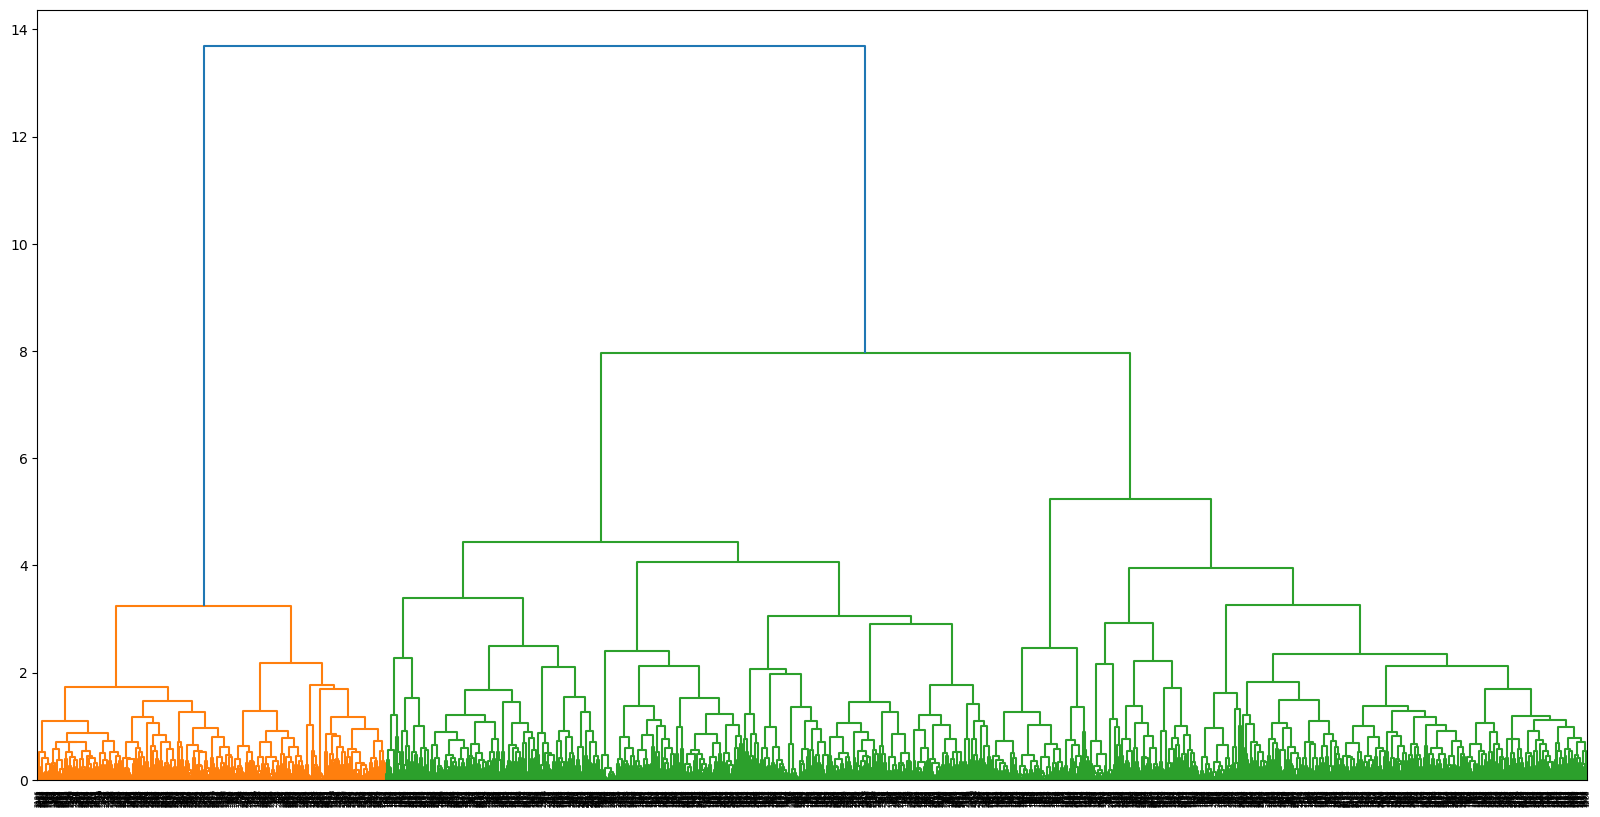

In [35]:
fig,ax = plt.subplots(figsize=(20,10))
_ = dendrogram(linkage_matrix, ax=ax)

In [73]:
clusters = fcluster(linkage_matrix, t=1, criterion='distance')

In [74]:
# from sklearn.cluster import KMeans, MiniBatchKMeans
# from sklearn.metrics import adjusted_rand_score
# clusters = KMeans(n_clusters=25, max_iter=5000, n_init=300).fit(embedding).labels_

In [75]:
# morh_clusters = results[label]
morh_clusters = region_cluster_labels.values

In [76]:
clusters = pd.Series(clusters, index=component_data.index.values)
clusters = clusters.loc[morh_clusters].values

In [77]:
# assert clusters.shape == results[label].shape

# for i in np.unique(results[label]):
#     idxs = np.where(results[label] == i)[0]
#     old_clusters = results[label][idxs]
#     new_clusters = clusters[idxs]
#     assert np.unique(old_clusters).shape[0] == 1
#     assert np.unique(new_clusters).shape[0] == 1
    

In [78]:
np.unique(clusters, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
        86, 87, 88, 89, 90, 91], dtype=int32),
 array([   37,   141,    73,    27,   249,    47,   128,   251,  1999,
          190,   136,   311,   204,   349,  2313,  2696,  2593,  2005,
         2842, 12666,  5182,  3344,  1443,  6010,  4153,  5115,  6451,
         2150,  5442,   861,  3565,  4877,   935,  3283,  2044, 10076,
         1897,  1870,  1714,  3482,  6512,   641,  1416,  4544,  4882,
         5923,  1680,  4200,  3931,  2532,  4049,  1380,  1625,   344,
         1358,  8030,  4787,  6318,  4671,  2153,  1472,   763,  1319,
         2782,  2428,  4722,  2388,  5125,  5743,  5355,   871,   225,
     

In [49]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(tessellation[tessellation.index >= 0], opacity=.08)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 4.78 s, sys: 351 ms, total: 5.13 s
Wall time: 5.12 s


In [50]:
from sidecar import Sidecar
sc = Sidecar(title='Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

In [79]:
from core.cluster_validation import get_color
layer.get_fill_color = get_color(clusters)

In [44]:
# clrs_geometry = tessellation.loc[region_cluster_labels.index]
# clrs_geometry['label'] = clusters
# clrs_geometry = clrs_geometry.dissolve('label').simplify(1).to_frame()
# clrs_geometry.columns = ['geometry']
# clrs_geometry = clrs_geometry.set_geometry('geometry')

In [45]:
# clrs_geometry.explore(column=clrs_geometry.index.values.astype(str), categorical=True)

In [231]:
clrs_geometry.to_parquet(f'../data/clusters__umap_{region_id}_{min_cluster_size}.pq')

In [51]:
from clustergram import Clustergram
from sklearn.mixture import GaussianMixture

In [52]:
component_data = X_train.loc[labels.groupby(labels).get_group(label).index.values]
component_data.shape

(166757, 126)

In [151]:
component_data = preprocess_clustering_data(component_data)
component_data.shape

(60555, 54)

In [ ]:
%%time
gmm = GaussianMixture(n_components=10, 
                      covariance_type="full",
                      max_iter=200, 
                      n_init=100,
                      random_state=42)
fitted = gmm.fit(component_data)
clusters = fitted.predict(component_data)
pd.Series(clusters, index=component_data.index).to_csv('../data/gmm_10_clusters.csv')

In [659]:
clusters = pd.read_csv('../data/gmm_10_clusters.csv').set_index('Unnamed: 0')